# Import the dependencies

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

# Some theory by ChatGPT:

Here are the top 10 methods commonly used for solving regression problems in Python:

1. Linear Regression: Fits a linear model to the data by minimizing the sum of squared residuals.
2. Decision Tree Regression: Uses a decision tree to make predictions based on feature values.
3. Random Forest Regression: An ensemble method that combines multiple decision trees to make predictions.
4. Gradient Boosting Regression: Builds an ensemble of weak prediction models (usually decision trees) sequentially, where each model corrects the mistakes of the previous one.
5. Support Vector Regression: Uses support vector machines to perform regression by finding the optimal hyperplane that maximally fits the data.
6. Neural Network Regression: Utilizes artificial neural networks to learn and model complex relationships in the data.
7. K-Nearest Neighbors Regression: Makes predictions based on the average of the target values of the k nearest neighbors in the feature space.
8. Ridge Regression: Performs linear regression with a penalty term to prevent overfitting by shrinking the coefficients.
9. Lasso Regression: Performs linear regression with a penalty term that encourages sparsity by forcing some coefficients to be exactly zero.
10. Elastic Net Regression: Combines Ridge and Lasso regression techniques to provide a balance between the two.

These methods offer different approaches and are suitable for various regression problem scenarios. It's important to understand their strengths and limitations and choose the most appropriate method based on your specific dataset, problem requirements, and computational considerations.

# Load data

In [2]:
data = pd.read_csv("src/train.csv")
data = data.drop("Id", axis=1)

data_test = pd.read_csv("src/test.csv")
data_test = data_test.drop("Id", axis=1)
data_test['SalePrice'] = pd.read_csv("src/sample_submission.csv")['SalePrice'].tolist()

# Preprocess data

### Define a pipeline for processing data

In [3]:
def preprocess_data(df_data: pd.DataFrame, preproc_obj=None):
    df_data = df_data.copy(deep=True)

    train_preprocessors = preproc_obj is None

    # Encoding Categorical Features
    if train_preprocessors:
        preproc_obj=dict()
        preproc_obj["ss"] = dict()
        preproc_obj["le"] = dict()
        preproc_obj["mms"] = dict()

    for col_name_ in df_data.columns:
        df_data[col_name_] = df_data[col_name_].fillna(0).tolist()

    for key_ in data.keys():
        if data[key_].dtypes == "object":
            if train_preprocessors:
                preproc_obj["le"][key_] = LabelEncoder()
                preproc_obj["le"][key_].fit(df_data[key_].to_list())
            df_data[key_] = preproc_obj["le"][key_].transform(df_data[key_].to_list())
        else:
            df_data[key_] = df_data[key_]

    if train_preprocessors:
        df_data.drop(df_data.index[-1], inplace=True)

    # Take log of the Target output
    df_data["SalePrice"] = np.log(df_data["SalePrice"])

    list_keep_data = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition', ]
    list_ss_data = ['MSSubClass', 'LotFrontage', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'YrSold', ]
    list_log_data = ['LotArea', '1stFlrSF', 'GrLivArea', ]

    for col_name_ in list_log_data:
        df_data[col_name_] = np.log(df_data[col_name_])

    for col_name_ in list_ss_data:
        if train_preprocessors:
            preproc_obj["ss"][col_name_] = StandardScaler()
            preproc_obj["ss"][col_name_].fit(np.array(df_data[col_name_]).reshape(-1, 1))
        df_data[col_name_] = preproc_obj["ss"][col_name_].transform(np.array(df_data[col_name_]).reshape(-1, 1))

    for col_name_ in df_data.columns:
        if col_name_ == 'SalePrice':
            continue
        if train_preprocessors:
            preproc_obj["mms"][col_name_] = MinMaxScaler(feature_range=(-1, 1))
            preproc_obj["mms"][col_name_].fit(np.array(df_data[col_name_]).reshape(-1, 1))
        df_data[col_name_] = preproc_obj["mms"][col_name_].transform(np.array(df_data[col_name_]).reshape(-1, 1))

    return df_data, preproc_obj

In [4]:
data_num_train, preprocessing_obj = preprocess_data(data)

In [5]:
data_num_train_short = data_num_train[["MSZoning", "LotArea", "LotShape", "Neighborhood", "HouseStyle", "OverallQual", "YearBuilt", "YearRemodAdd", "RoofStyle", "MasVnrType", "MasVnrArea", "ExterQual", "Foundation", "BsmtQual", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "HeatingQC", "CentralAir", "Electrical", "1stFlrSF", "2ndFlrSF", "GrLivArea", "BsmtFullBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "PavedDrive", "WoodDeckSF", "OpenPorchSF", "SaleCondition"]]

In [6]:
data_num_test, _ = preprocess_data(data_test, preprocessing_obj)
data_num_test_short = data_num_test[["MSZoning", "LotArea", "LotShape", "Neighborhood", "HouseStyle", "OverallQual", "YearBuilt", "YearRemodAdd", "RoofStyle", "MasVnrType", "MasVnrArea", "ExterQual", "Foundation", "BsmtQual", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "HeatingQC", "CentralAir", "Electrical", "1stFlrSF", "2ndFlrSF", "GrLivArea", "BsmtFullBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "PavedDrive", "WoodDeckSF", "OpenPorchSF", "SaleCondition"]]

# Do cluster analysis

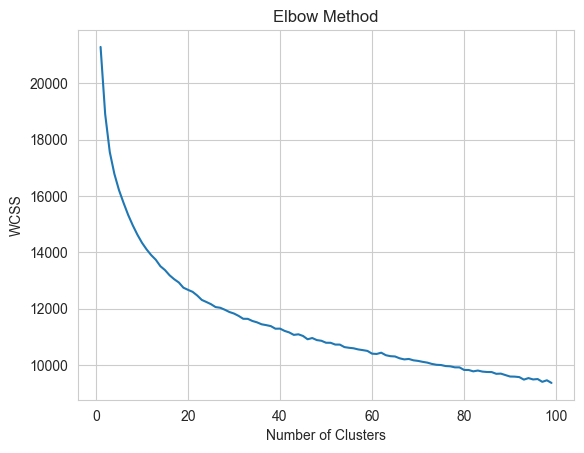

In [7]:
wcss = []

for n_clusters in range(1, 100):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    model.fit(data_num_train.drop("SalePrice", axis=1))

    wcss.append(model.inertia_)

plt.plot(range(1, 100), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

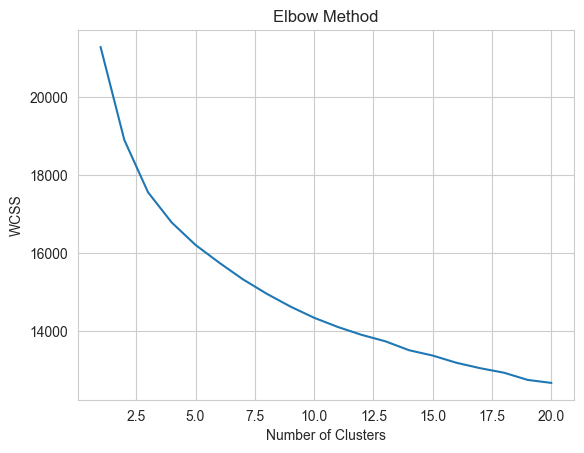

In [8]:
wcss = []

for n_clusters in range(1, 21):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    model.fit(data_num_train.drop("SalePrice", axis=1))

    wcss.append(model.inertia_)

plt.plot(range(1, 21), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [31]:
tn_clusters = 5

kmeans_model = KMeans(n_clusters=tn_clusters, random_state=42, n_init=200)
kmeans_model.fit(data_num_train.drop("SalePrice", axis=1))

KMeans(n_clusters=5, n_init=200, random_state=42)

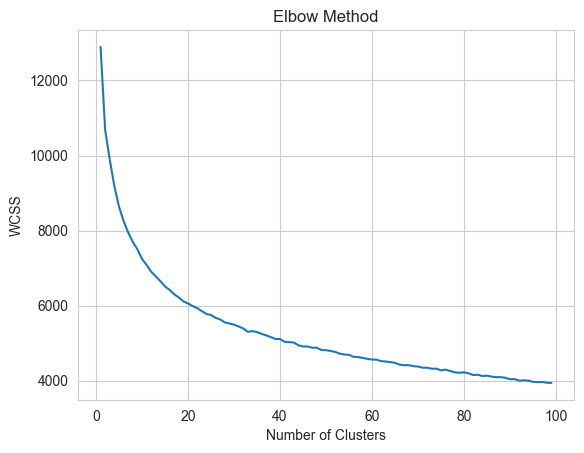

In [10]:
wcss = []

for n_clusters in range(1, 100):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    model.fit(data_num_train_short)

    wcss.append(model.inertia_)

plt.plot(range(1, 100), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

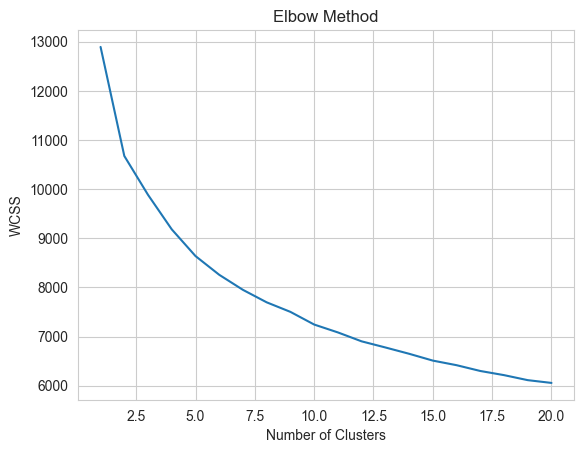

In [11]:
wcss = []

for n_clusters in range(1, 21):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    model.fit(data_num_train_short)

    wcss.append(model.inertia_)

plt.plot(range(1, 21), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [12]:
tn_clusters_short = 10

kmeans_model_short = KMeans(n_clusters=tn_clusters_short, random_state=42, n_init=200)
kmeans_model_short.fit(data_num_train_short)

KMeans(n_clusters=10, n_init=200, random_state=42)

# Visualize with PCA

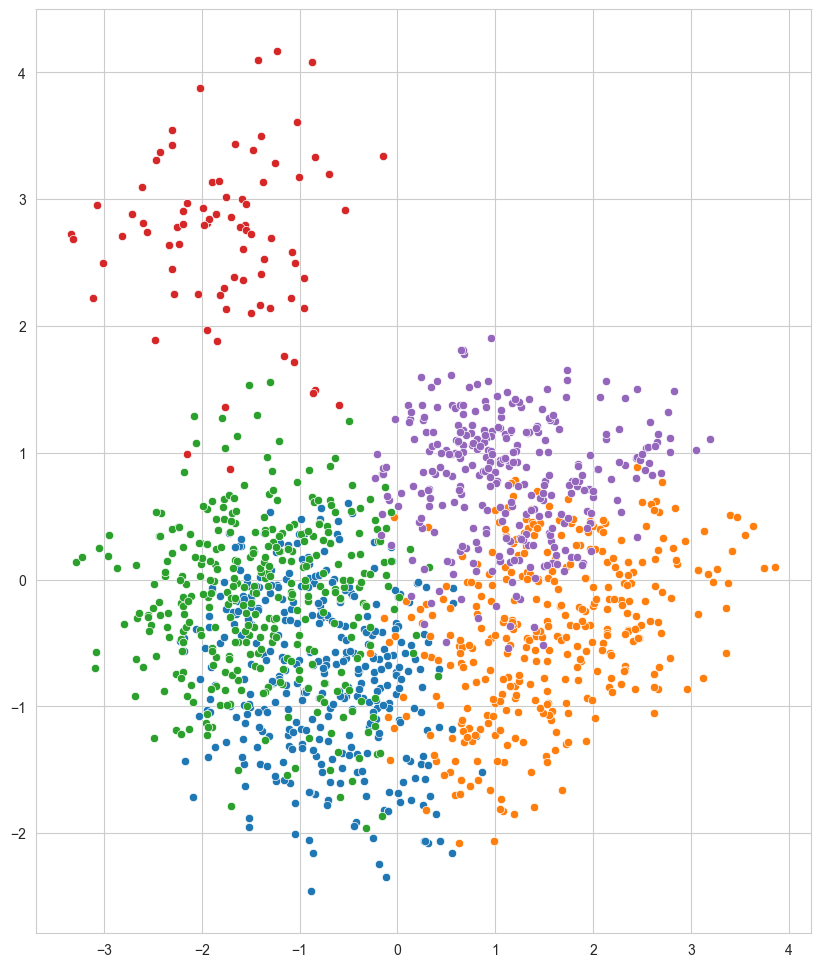

In [32]:
pca = PCA(2, random_state=42)
pca.fit(data_num_train.drop("SalePrice", axis=1))

train_cl_pred = list(kmeans_model.predict(data_num_train.drop("SalePrice", axis=1)))

for cluster_no in range(tn_clusters):
    data_pca = pca.transform(data_num_train.drop("SalePrice", axis=1)[[cluster_no == cluster_no_ for cluster_no_ in train_cl_pred]])
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1])

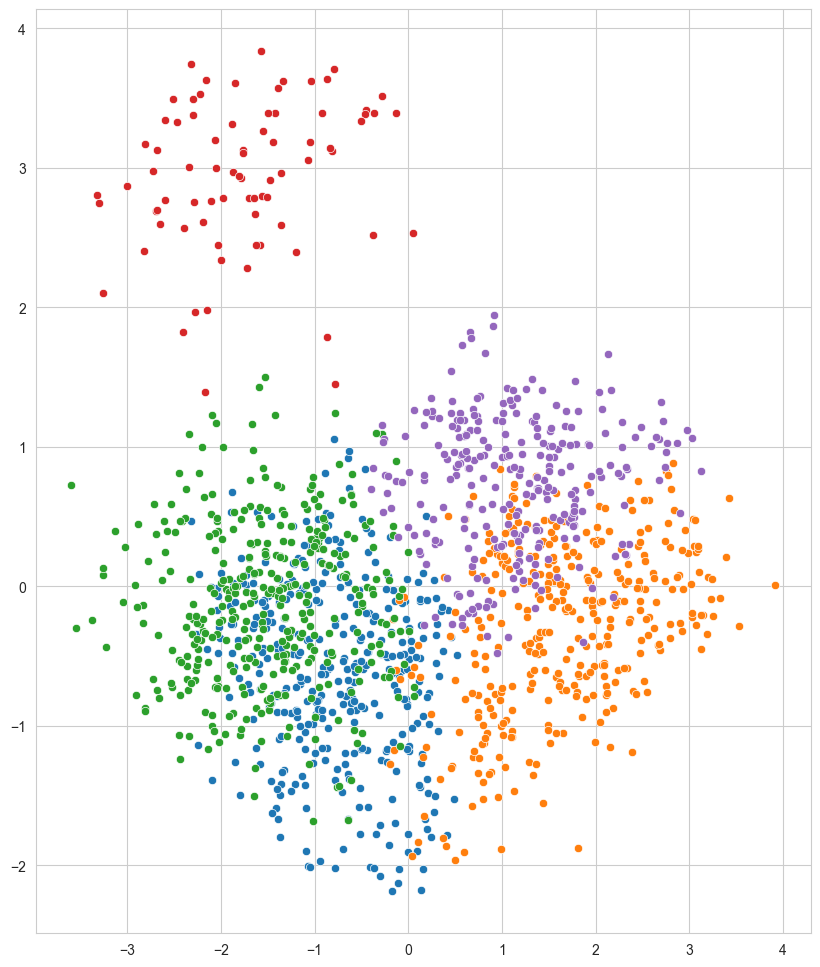

In [33]:
test_cl_pred = list(kmeans_model.predict(data_num_test.drop("SalePrice", axis=1)))

for cluster_no in range(tn_clusters):
    data_pca = pca.transform(data_num_test.drop("SalePrice", axis=1)[[cluster_no == cluster_no_ for cluster_no_ in test_cl_pred]])
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1])

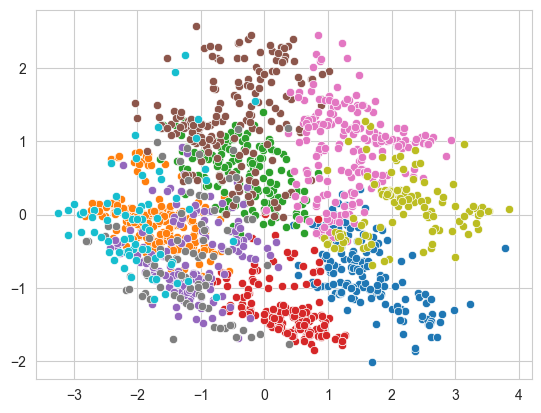

In [16]:
pca = PCA(2, random_state=42)
pca.fit(data_num_train_short)

train_cl_pred_short = list(kmeans_model_short.predict(data_num_train_short))

for cluster_no in range(tn_clusters_short):
    data_pca = pca.transform(data_num_train_short[[cluster_no == cluster_no_ for cluster_no_ in train_cl_pred_short]])
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1])

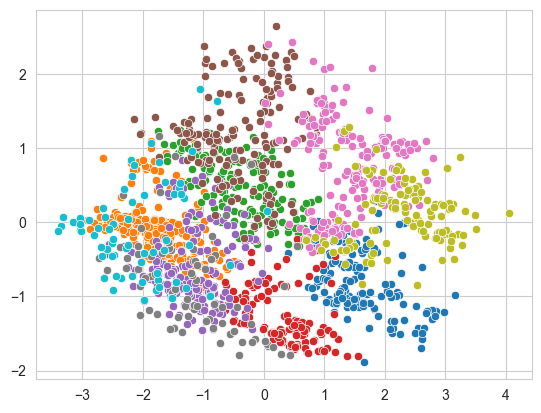

In [17]:
test_cl_pred_short = list(kmeans_model_short.predict(data_num_test_short))

for cluster_no in range(tn_clusters_short):
    data_pca = pca.transform(data_num_test_short[[cluster_no == cluster_no_ for cluster_no_ in test_cl_pred_short]])
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1])

# Full data & Linear Regression Ensemble

In [18]:
rcParams['figure.figsize'] = 10, 12

def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()


def predict_by_ensemble(ens_models: list, cl_model: KMeans, data_to_predict: pd.DataFrame):
    list_preds = []
    for _, record in data_to_predict.iterrows():
        selected_model = ens_models[cl_model.predict(pd.DataFrame(record.to_dict(), index=[0]))[0]]
        list_preds.append(selected_model.predict(pd.DataFrame(record.to_dict(), index=[0]))[0])
    return list_preds

In [34]:
ensemble_models = [LinearRegression() for _ in range(tn_clusters)]
# kmeans_model -- is a model for selecting appropriate model
for cluster_no in range(tn_clusters):
    data_selector = [cluster_no == cluster_no_ for cluster_no_ in train_cl_pred]
    ensemble_models[cluster_no].fit(data_num_train.drop('SalePrice', axis=1)[data_selector], data_num_train['SalePrice'][data_selector])

0.009402131618780406


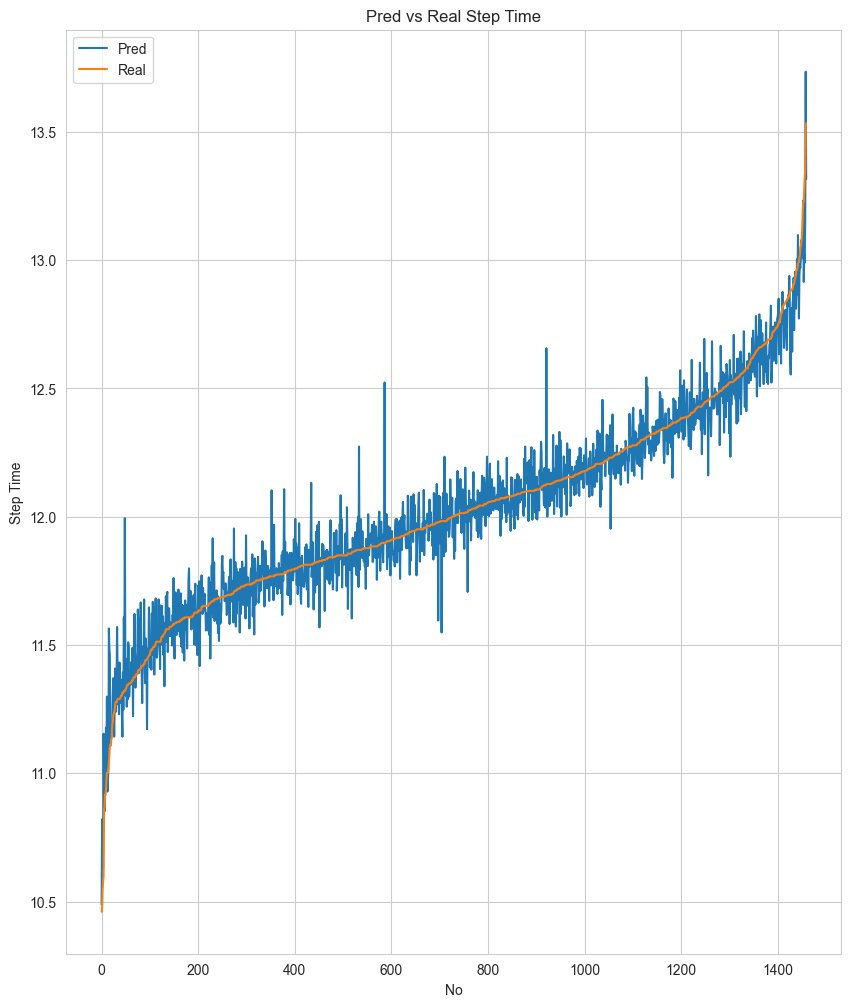

In [35]:
train_pred = predict_by_ensemble(ensemble_models, kmeans_model, data_num_train.drop('SalePrice', axis=1))
rmse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, squared=True)
print(rmse_train)

draw_pred_lines(train_pred, data_num_train['SalePrice'].to_list())

0.6308062568470877


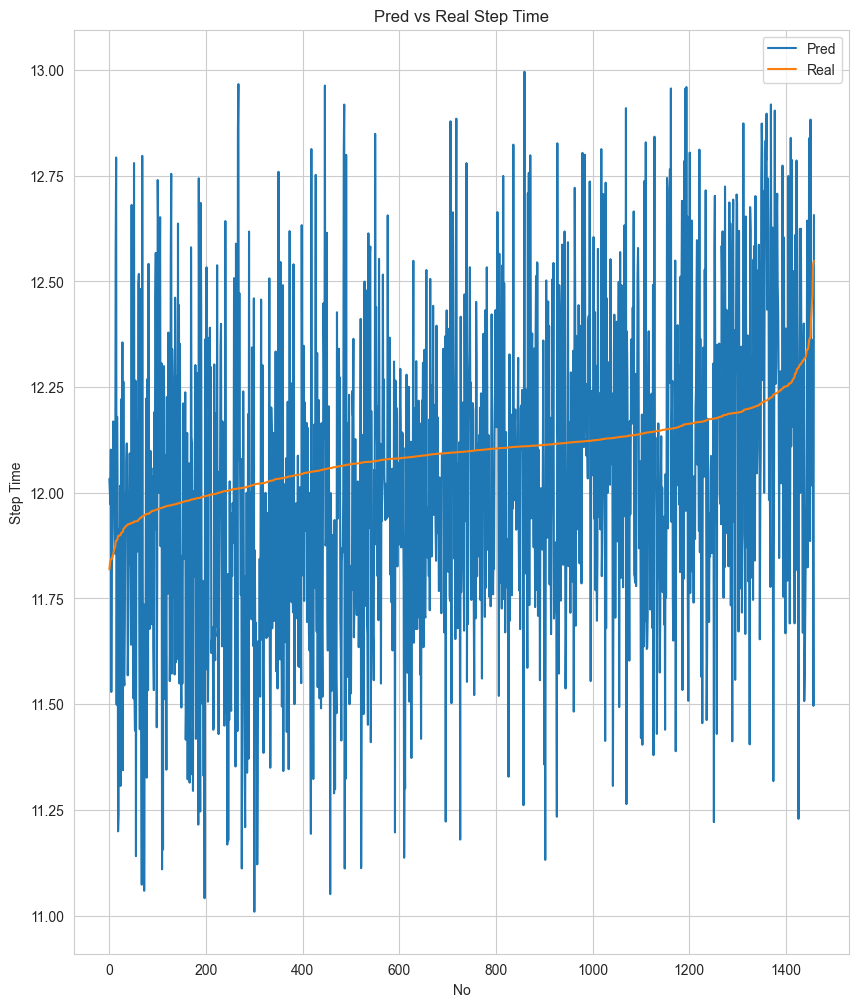

In [37]:
test_pred = predict_by_ensemble(ensemble_models, kmeans_model, data_num_test.drop('SalePrice', axis=1))
rmse_test = mean_squared_error(data_num_test['SalePrice'], [-1.0 if tp < 0.0 or abs(tp) > 20 else tp for tp in test_pred], squared=False)
print(rmse_test)

draw_pred_lines([12 if tp < 11.0 or tp > 13.0 else tp for tp in test_pred], data_num_test['SalePrice'].to_list())

# Part Data & Linear Regression

0.13938773558592796


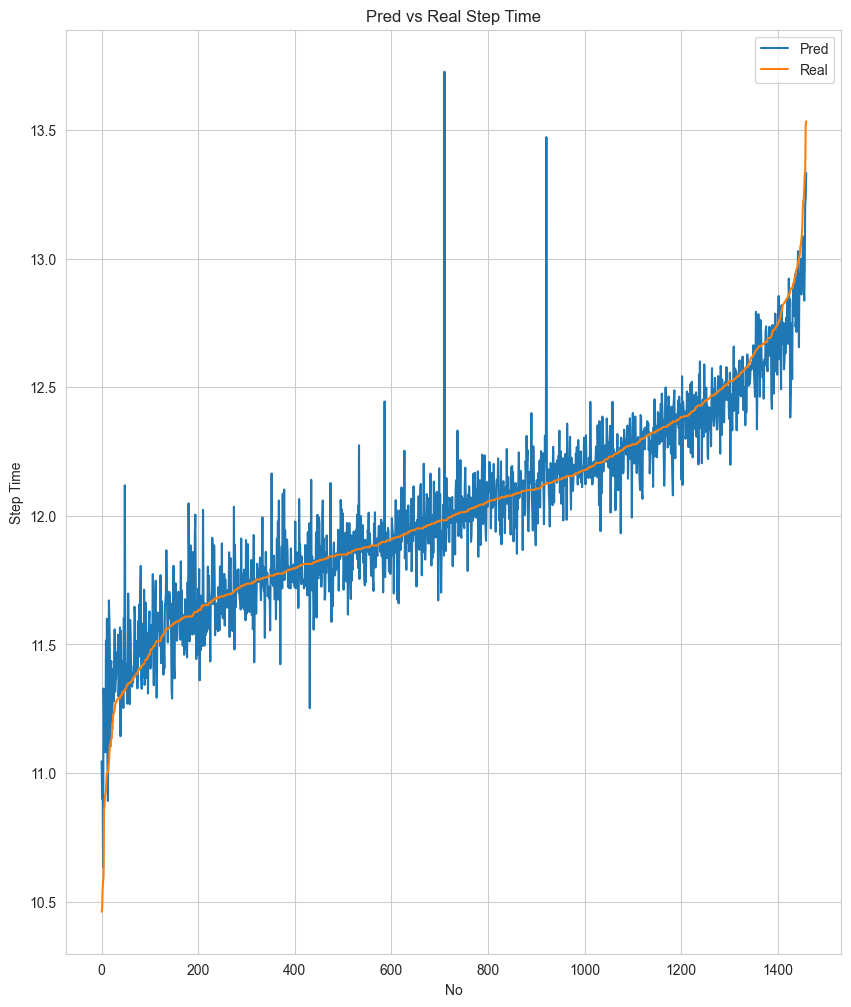

In [32]:
linear_regressor = LinearRegression()
linear_regressor.fit(data_num_train_short, data_num_train['SalePrice'])

train_pred = linear_regressor.predict(data_num_train_short)
rmse_train = mean_squared_error(data_num_train['SalePrice'], train_pred, squared=False)
print(rmse_train)

draw_pred_lines(train_pred, data_num_train['SalePrice'].to_list())

0.37646650592912007


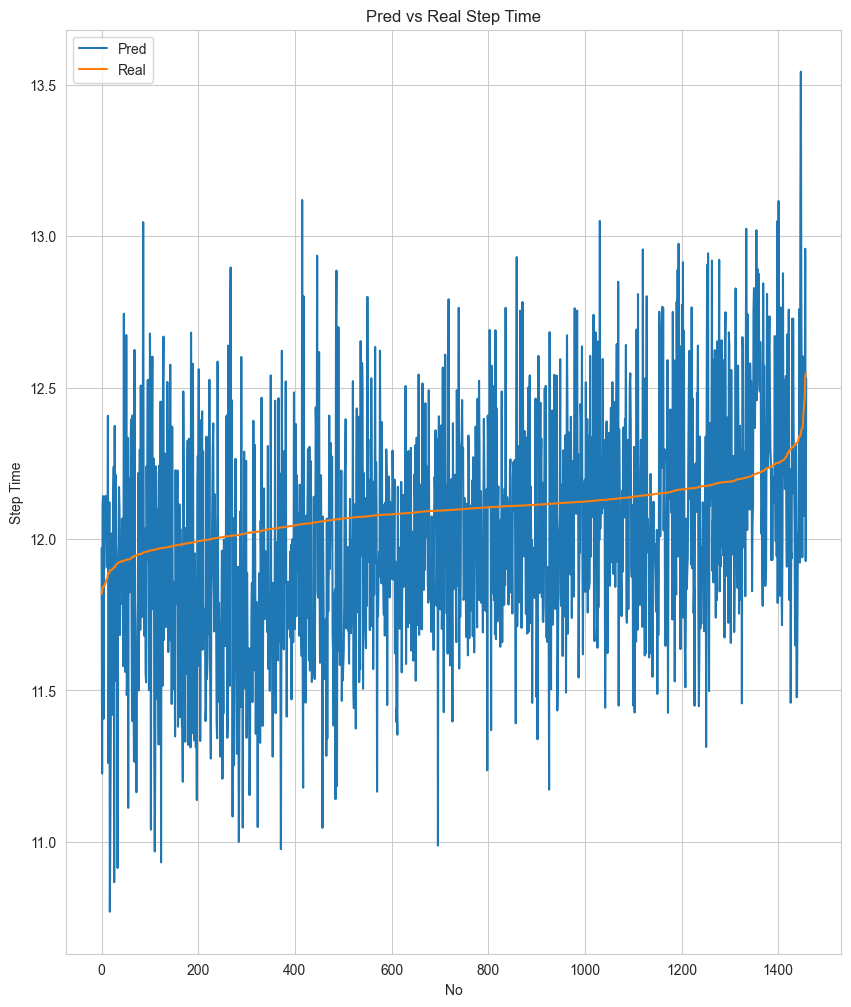

In [33]:
test_pred = linear_regressor.predict(data_num_test_short)
rmse_test = mean_squared_error(data_num_test['SalePrice'], test_pred, squared=False)
print(rmse_test)

draw_pred_lines(test_pred, data_num_test['SalePrice'].to_list())